In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tradingWithPython as twp
import tradingWithPython.lib.yahooFinance as yf
from tradingWithPython import sharpe
import pandas as pd 
twp.extra.setNotebookStyle()

In [3]:
ohlc = yf.getHistoricData('XLP')[['open','high','low','close']] #直接调整所需要的列，而且是多列

Got 4546 days of data


In [4]:
ohlc.head()

,open,high,low,close
1998-12-22,25.88,26.53,25.88,26.50
1998-12-23,26.80,28.80,26.69,27.14
1998-12-24,27.14,27.14,27.00,27.09
1998-12-28,27.14,27.16,26.81,26.94
1998-12-29,26.95,27.56,25.98,27.53


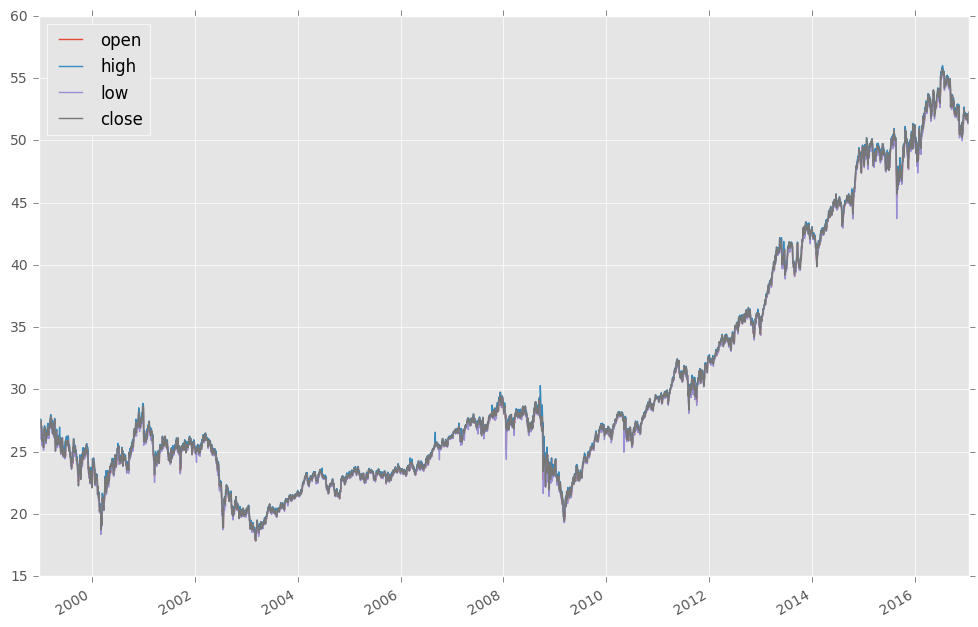

In [5]:
ohlc.plot()

交易策略，昨日跌0.25%，今日开盘跌0.1以上。这里是针对spy指数的策略。 

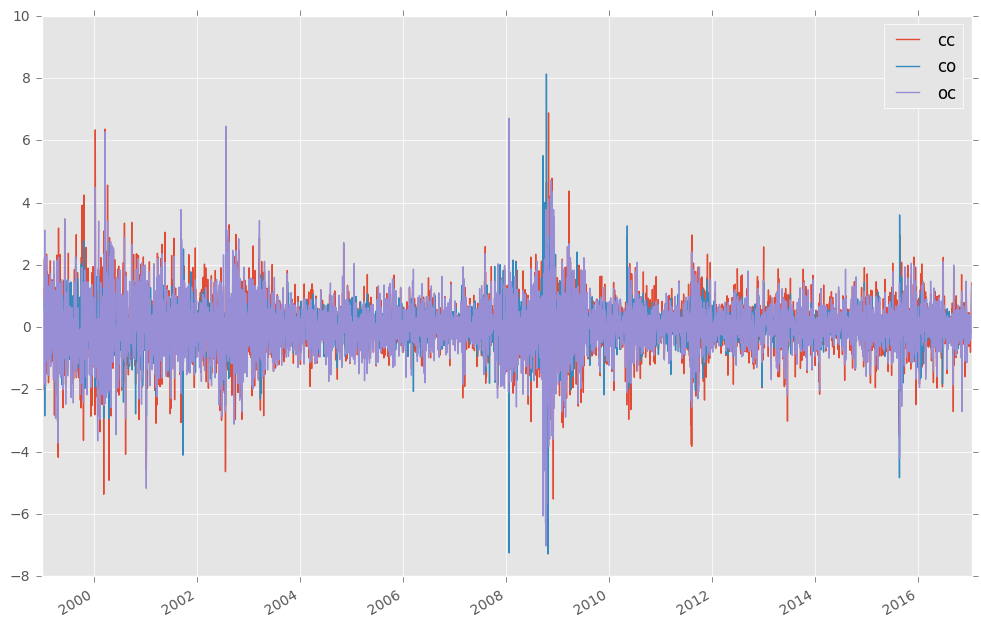

In [6]:
stratData = pd.DataFrame(index=ohlc.index) #建立与历史数据index相同的数据
stratData['cc'] = 100 * ohlc['close'].pct_change() #每日收盘与前日收盘的涨跌幅
stratData['co'] = 100 * (ohlc['open'] / ohlc['close'].shift(1) -1)#昨日收盘于今日开盘涨跌幅
stratData['oc'] = 100 * (ohlc['close'] / ohlc['open'] - 1) #当天涨跌幅
stratData.plot()

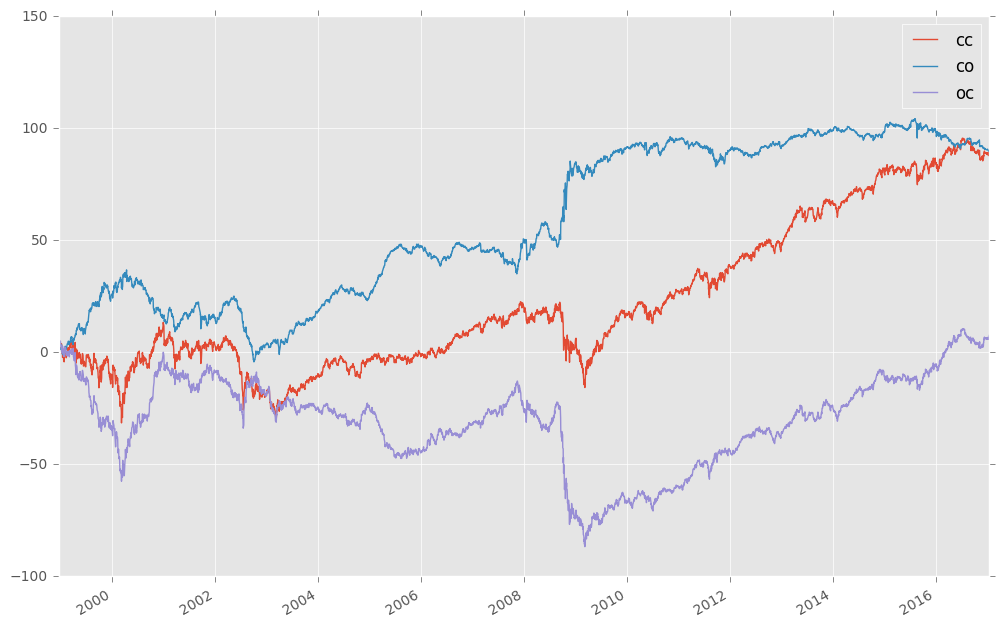

In [7]:
stratData.cumsum().plot()

In [8]:
idx = (stratData['cc']<-0.25).shift(1) & (stratData['co']<-0.1) #直接获得一个series,index与stratData一致，而且是前一天的跌幅小于0.25
#shift(1)表示前一天满足条件

In [9]:
idx #获得布尔值序列

1998-12-22    False
1998-12-23    False
1998-12-24    False
1998-12-28    False
1998-12-29    False
              ...  
2017-01-10    False
2017-01-11     True
2017-01-12    False
2017-01-13    False
2017-01-17    False
dtype: bool

In [10]:
idx[0] = False


In [11]:
type(idx)

pandas.core.series.Series

In [12]:
stratData['goLong'] = idx
stratData['pnl'] = 0. #初始仓位为0,一定记得加上小数点
stratData.ix[idx, 'pnl'] = stratData.ix[idx, 'oc'] #如果某日的idx是true，也即附和买入条件，那么当日的pnl就等于当日收盘比开盘涨幅。因为策略是当日收盘清仓。 
stratData.tail(20)

,cc,co,oc,goLong,pnl
2016-12-16,-0.17,-0.42,0.25,False,0.00
2016-12-19,0.19,0.12,0.08,False,0.00
2016-12-20,-0.19,0.04,-0.23,False,0.00
2016-12-21,-0.02,-0.10,0.08,False,0.00
2016-12-22,-0.15,-0.12,-0.04,False,0.00
...,...,...,...,...,...
2017-01-10,-0.50,-0.10,-0.41,False,0.00
2017-01-11,0.19,-0.17,0.37,True,0.37
2017-01-12,-0.10,-0.04,-0.06,False,0.00
2017-01-13,0.06,0.00,0.06,False,0.00


In [13]:
sharpe(stratData['pnl'])

1.1137731020435266

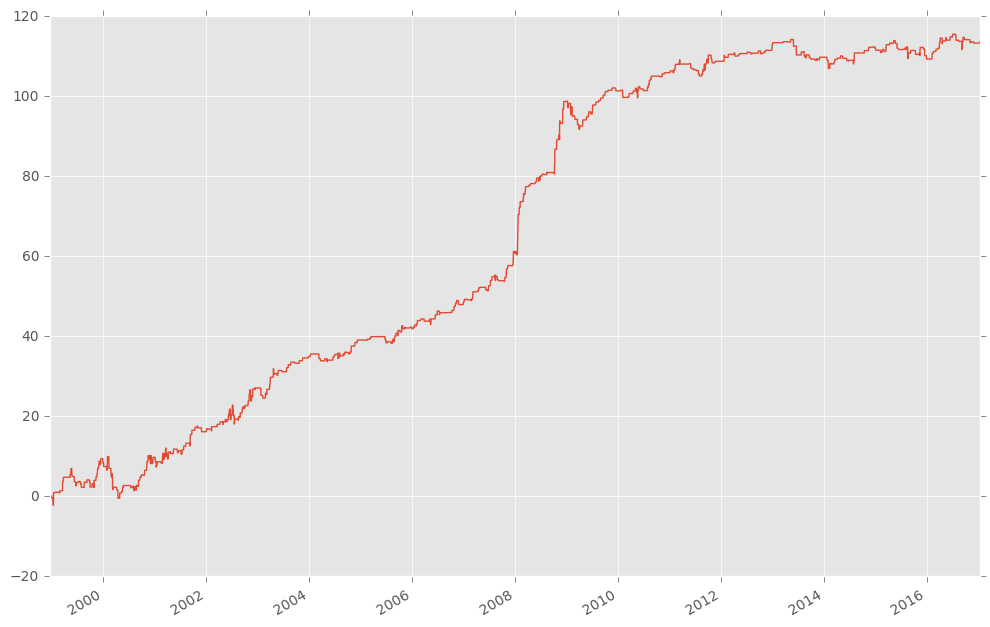

In [14]:
stratData['pnl'].cumsum().plot(grid=True)

In [17]:
def backtest(ohlc, ccThresh=-0.25, coThresh=-0.1):
    '''
    function to backtest the strategy of percentage change in stock price of the current day & a day before
    
    parameters
    ==========
    ohlc: DataFrame
        historial open, high, low, close price 
    ccThresh: float
        percentage decline one day before
    coThresh: float
        percentage decline of current day's open relative to the close of one day before
    '''
    stratData = pd.DataFrame(index=ohlc.index)
    stratData['cc'] = 100*ohlc['close'].pct_change() # close-to-close change in %
    stratData['co'] = 100*(ohlc['open']/ohlc['close'].shift(1)-1) # previous close to open change in %
    stratData['oc'] = 100*(ohlc['close']/ohlc['open']-1) # open to close change in %

    idx = (stratData['cc']<ccThresh).shift(1) & (stratData['co']<coThresh)
    idx[0] = False
    
    stratData['goLong'] = idx
    stratData['pnl'] = 0. # init pnl column with zeros (Watch out: if initialized with integer value (0), an error will pop later on)
    stratData.ix[idx,'pnl'] = stratData.ix[idx, 'oc'] # set pnl column values to daily return wehere 'goLong' is true
    
    return stratData['pnl']

Sharpe: 1.11377310204


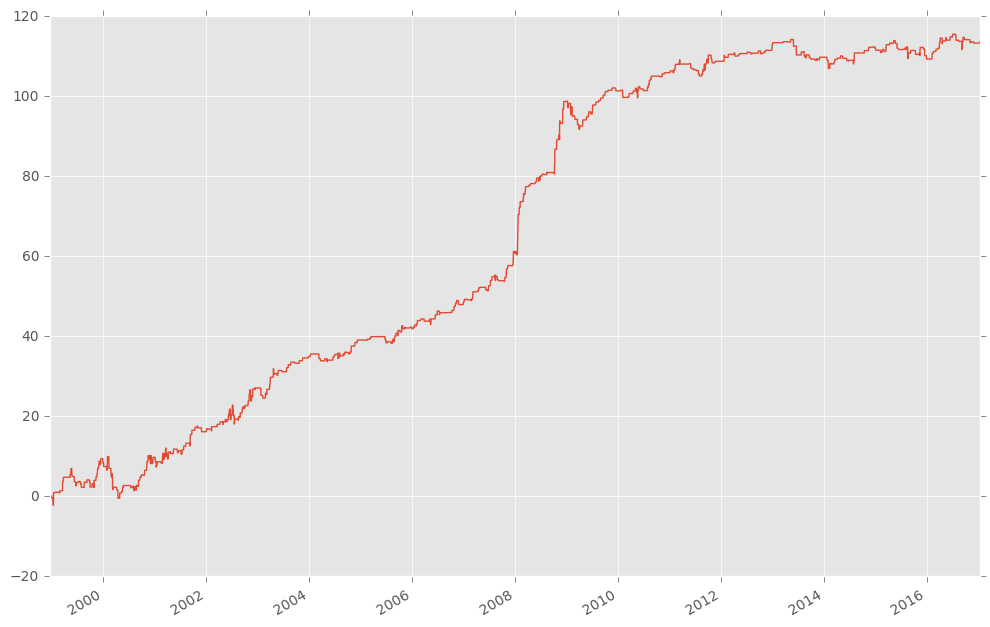

In [19]:
pnl = backtest(ohlc)
pnl.cumsum().plot()
print('Sharpe:', sharpe(pnl))

In [32]:
from tradingWithPython.lib.extra import ProgressBar
ccThresh = np.linspace(-1, 1, 30)
coThresh = np.linspace(-0.5, 0.5, 30)
pbar = ProgressBar(len(ccThresh)-1)

In [28]:
SH = np.zeros((len(ccThresh), len(coThresh)))

In [33]:
for i, cc in enumerate(ccThresh):
    pbar.animate(i)
    for j, co in enumerate(coThresh):
        pnl = backtest(ohlc, cc, co)
        SH[i, j] = sharpe(pnl)

 [*********************100%***********************]  29 of 29 complete

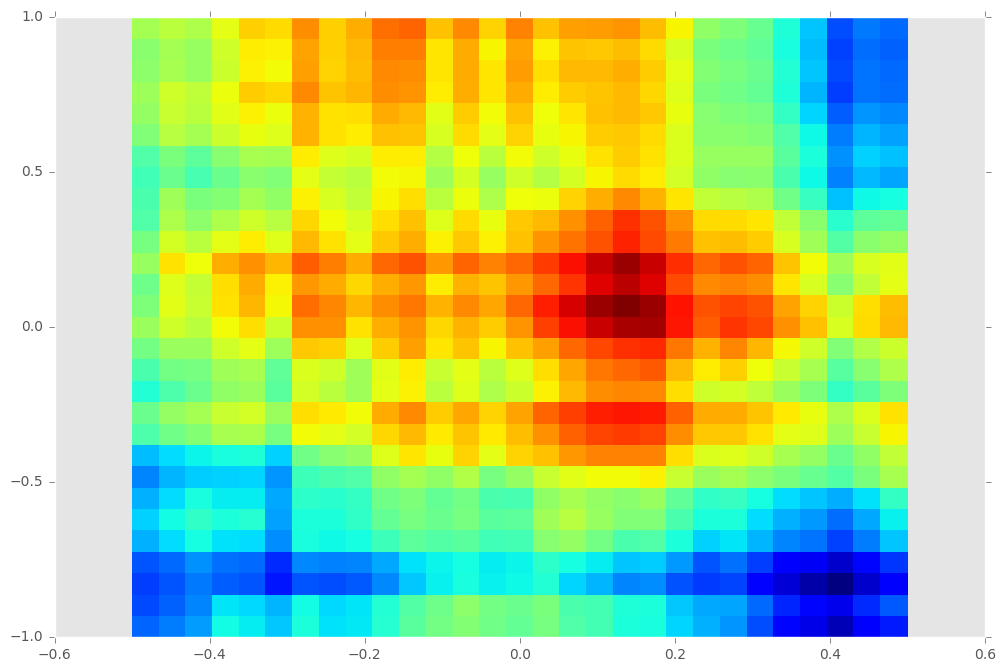

In [34]:
pcolor(coThresh, ccThresh, SH)

In [35]:
i,j = np.unravel_index(SH.argmax(), SH.shape)
SH[i,j]
print('Optimum CC %.2f' % ccThresh[i])
print('Optimum CO %.2f' % coThresh[j])

Optimum CC 0.03
Optimum CO 0.12


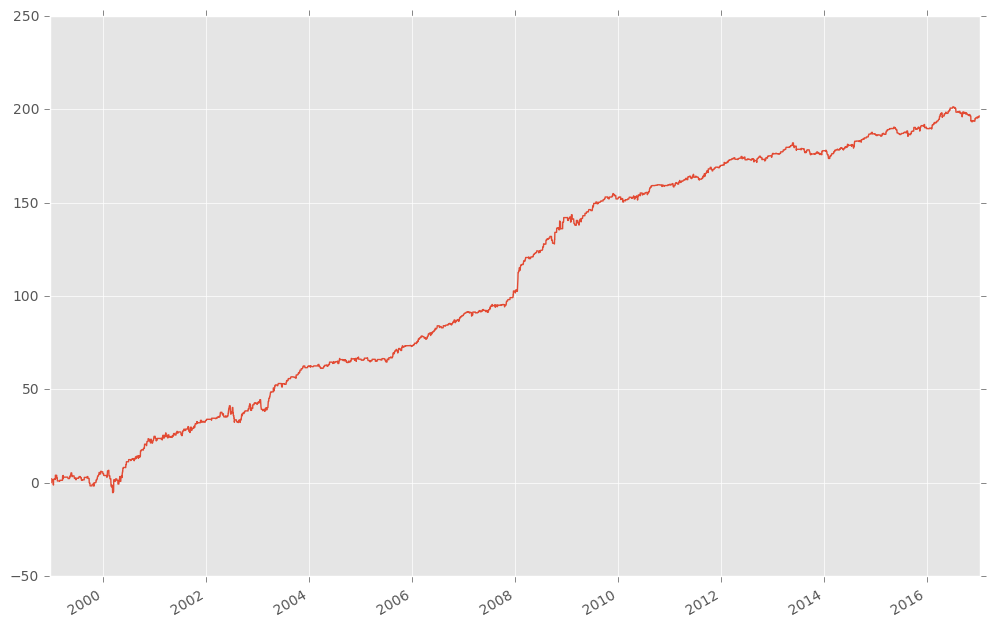

In [37]:
pnl = backtest(ohlc, ccThresh=0.03, coThresh=0.12) #使用最优参数进行回测
pnl.cumsum().plot()